In [1]:
import fitz
import io
import os
from PIL import Image
import cv2
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from psutil import virtual_memory
import numpy as np
import sys
import time
import pkgutil


In [12]:
fids = [fid.path for fid in os.scandir('ava_specific/') if 'pdf' in fid.name]
len([fid.path for fid in os.scandir('ava_specific/') if 'pdf' in fid.name])

5

In [13]:

for fid in fids:
    pdf = fitz.open(fid)
    name = pdf.name.split('/')[-1]
    print('\n'+name)


Ma, Liu, Wen Chen - 2017 - A-lamp Adaptive layout-aware multi-patch deep convolutional neural network for photo aesthetic assessment-annotated.pdf

Hosu, Goldlucke, Saupe - 2019 - Effective aesthetics prediction with multi-level spatially pooled features-annotated.pdf

Talebi, Milanfar - 2018 - NIMA Neural Image Assessment-annotated.pdf

aesthetics_cvpr11.pdf

Sheng et al. - 2018 - Attention-based multi-patch aggregation for image aesthetic assessment-annotated.pdf


is a computaiton of the multiplicative index of three terms- luminance, contrast, structural:

$$SSIM(x,y) = [l(x,y]^\alpha \cdot [c(x,y)]^\beta \cdot [s(x,y)]^\gamma  $$

where: 

$$l(x,y) = \frac{2\mu_x\mu_y + C_1}{\mu^2_x + \mu^2_y + C_2} $$
$$c(x,y) = \frac{2\sigma_x\sigma_y + C_2}{\sigma^2_x + \sigma^2_y + C_2} $$
$$s(x,y) = \frac{2\sigma_{xy} + C_3}{\sigma_x + \sigma_y + C_3} $$

$\mu_x \mu_y$ are local means
$\sigma_x \sigma_y $ is the local standard deviation
$\sigma_xy$ cross-co varince 

therefore:

$$SSIM(x,y) = \frac{(2\mu_x\mu_y +C_1)(2\sigma_{xy} + C_2)}{(\mu^2_x + \mu^2_y + C_1)(\sigma^2_x + \sigma^2_y + C_2)}$$


In [14]:
if not os.path.isdir('retrived_images'):
    os.mkdir('retrived_images')
for raw_pdf in fids:
    pdf = fitz.open(raw_pdf)
    name = pdf.name.split('/')[-1]
    for page_id in range(len(pdf)):
        page = pdf[page_id]
        im_lst = page.getImageList()
        if im_lst:
            for id_, img in enumerate(page.getImageList(), start=1):
                    raw = img[0]
                    image = pdf.extractImage(raw)
                    if image!=None:
                        rw_img = pdf.extract_image(raw)
                        img_b = rw_img['image']
                        im_array = np.frombuffer(img_b, np.uint8)
                        img = cv2.imdecode(im_array, -1)
                        cv2.imwrite('retrived_images/'+str(page_id)+name+str(id_)+'.'+rw_img['ext'],img)

                        



In [18]:
ims = [fid.path for fid in os.scandir('retrived_images/')]
print(ims[0])
# this is a duplictae but you would replace this with images
# that you want to cross reference with
ava_fids = [fid.path for fid in os.scandir('images_sample_database/')]


retrived_images/6Sheng et al. - 2018 - Attention-based multi-patch aggregation for image aesthetic assessment-annotated.pdf43.jpeg


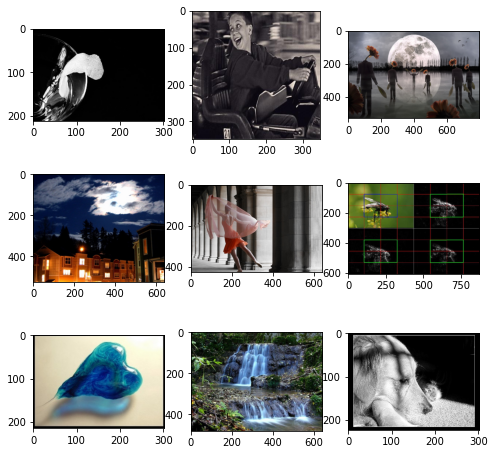

In [20]:
#plots and example of 3,3 ims that have been pulled from pdf documnets
# these are for cross referencing
imgs =  (cv2.cvtColor(cv2.imread(ims[i]), cv2.COLOR_BGR2RGB) for i in range(9))
fig, ax = plt.subplots(3,3, figsize=(8,8))
for i in range(3):
    for j in range(3):
        ax[i,j].imshow(next(imgs))


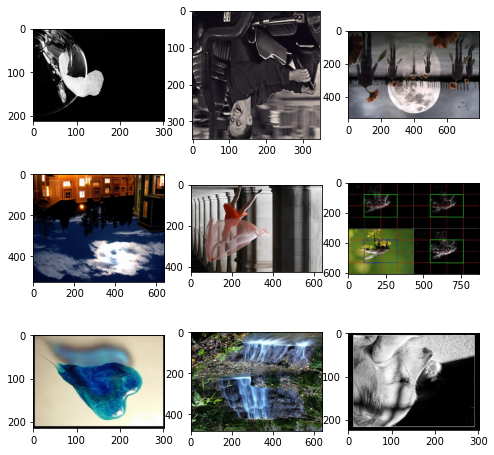

In [21]:
imgs =  (cv2.cvtColor(cv2.imread(art[i]), cv2.COLOR_BGR2RGB) for i in range(9))
fig, ax = plt.subplots(3,3, figsize=(8,8))
for i in range(3):
    for j in range(3):
        ax[i,j].imshow(cv2.flip(next(imgs),0))


#### The below cell contians a simple algorythm for matching images using  Structural Similarity Index (SSIM). 

SSIM is outlined by Z. Wang et. al[1] is a computaiton of the multiplicative index of three terms- luminance, contrast, structural:

$$SSIM(x,y) = [l(x,y]^\alpha \cdot [c(x,y)]^\beta \cdot [s(x,y)]^\gamma  $$

where: 

$$l(x,y) = \frac{2\mu_x\mu_y + C_1}{\mu^2_x + \mu^2_y + C_2} $$
$$c(x,y) = \frac{2\sigma_x\sigma_y + C_2}{\sigma^2_x + \sigma^2_y + C_2} $$
$$s(x,y) = \frac{2\sigma_{xy} + C_3}{\sigma_x + \sigma_y + C_3} $$

$\mu_x \mu_y$ are local means
$\sigma_x \sigma_y $ is the local standard deviation
$\sigma_xy$ cross-co varince 

therefore:

$$SSIM(x,y) = \frac{(2\mu_x\mu_y +C_1)(2\sigma_{xy} + C_2)}{(\mu^2_x + \mu^2_y + C_1)(\sigma^2_x + \sigma^2_y + C_2)}$$

ssim of 1 is an exact match to the image



[1]Wang, Z., Bovik, A. C., Sheikh, H. R., & Simoncelli, E. P. (2004). Image quality assessment: From error visibility to structural similarity. IEEE Transactions on Image Processing, 13(4), 600–612. https://doi.org/10.1109/TIP.2003.819861


In [22]:


def matcher(image, batch):
    # created and empty numpy array
    vec = np.zeros(len(batch))
    # if opne CV read returns None Type 
    # then renturns zero value array 
    # a fail safe as some of the iamages pulled
    # (scraped) from pdf's may not be readable
    if image is None:
        return vec
    else:
        #converts to greyscale
        img_a = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
        #computes heigh and width
        width = img_a.shape[1]
        height = img_a.shape[0]
        dim = (width, height)
        for idx in range(len(batch)):
            if batch[idx] is None:
                # not all id'd images in documents are 
                # readable therfore set 0 where this is the case
                vec[idx]=0
            else:
                # converts image to be compared to origional 
                # to greyscale (there is an equetion for this)
                img_b = cv2.cvtColor(batch[idx], cv2.COLOR_BGR2GRAY)
                # resizes image to dimensions of image being cross
                # referenced
                small = cv2.resize(img_b, dim, interpolation = cv2.INTER_AREA)
                if small.shape == (img_a.shape):
                    flips = [small]+[cv2.flip(small,i) for i in range(2)]
                    vec[idx]=max([ssim(img,img_a, multichannel=True) for img in flips])
        # returns a 1D array of ssim score of all images        
    return vec

In [23]:
## rending images into virtual memory 
# will speed up above code and this may effect what batch size that you use
# therfor including GB of free RAM
mem = virtual_memory()
free = mem.free/1024**3
total = mem.total/1024**3
print(f'Avalable RAM G.bytes = {free:.2f} , Total RAM G. Bytes = {total:.2f}')

Avalable RAM G.bytes = 5.05 , Total RAM G. Bytes = 23.39


In [24]:

batch = [cv2.imread(i) for i in ims]
batch_size = sys.getsizeof(batch)/1024**2
print(f'Avalable RAM in M. Bytes= {batch_size:.8f}')

Avalable RAM in M. Bytes= 0.00102997


In [94]:
t_zero = time.time()
# reads a bacth of images at once
# can be optimized according to ram capaciyt

matches = {img:matcher(cv2.imread(img),batch) for img in ims}

delta_t = time.time()-t_zero
print(f' time seconds to compare batch {delta_t:.2f}')


KeyboardInterrupt: 

In [95]:
match_matrix = np.vstack([matches[match_array] for match_array in matches])
print(match_matrix[:2])

[[1.         0.31368725 0.3454438  0.01437631 0.18510136 0.23954752
  0.25536409 0.11726879 0.178098   0.30704419 0.41157148 0.22921798
  0.36346649 0.24863073 0.35083266 0.16397855 0.17903732 0.16050528
  0.17099649 0.29651336 0.31927223 0.44498854 0.24744357 0.41185719
  0.45208528 0.36968276 0.29357958 0.27158955 0.17040294 0.13476984
  0.26104485 0.13692313 0.4190778  0.19112313 0.37601628 0.18638638
  0.24901625]
 [0.23375547 1.         0.30221408 0.01827127 0.14231879 0.17131687
  0.19361305 0.16047063 0.14426784 0.29306456 0.26451668 0.23907342
  0.24923989 0.17711906 0.35634913 0.13764286 0.1188157  0.15828525
  0.20524691 0.22998055 0.23119351 0.45864257 0.2712716  0.39783146
  0.3935835  0.32664778 0.21277009 0.17593322 0.1412543  0.12946346
  0.25748448 0.17192055 0.39250571 0.18155851 0.35931532 0.22380564
  0.2097023 ]]


## Bibleography

Liu, Z., Wang, J., Gong, S., Tao, D., & Lu, H. (2019). Deep reinforcement active learning for human-in-the-loop person re-identification. Proceedings of the IEEE International Conference on Computer Vision, 2019-October, 6121–6130. https://doi.org/10.1109/ICCV.2019.00622

Sun, P., Zhang, W., Wang, H., Li, S., & Li, X. (2021). Deep RGB-D Saliency Detection with Depth-Sensitive Attention and Automatic Multi-Modal Fusion. 1407–1417. http://arxiv.org/abs/2103.11832

Su, H., Niu, J., Liu, X., Li, Q., Wan, J., Xu, M., & Ren, T. (2020). An End-to-end Method for Producing Scanning-robust Stylized QR Codes. http://arxiv.org/abs/2011.07815


Cheng, J., Jaiswal, A., Wu, Y., Natarajan, P., & Natarajan, P. (2021). Style-Aware Normalized Loss for Improving Arbitrary Style Transfer. 134–143. http://arxiv.org/abs/2104.10064

Hosu, V., Goldlucke, B., & Saupe, Di. (2019). Effective aesthetics prediction with multi-level spatially pooled features. Proceedings of the IEEE Computer Society Conference on Computer Vision and Pattern Recognition, 2019-June, 9367–9375. https://doi.org/10.1109/CVPR.2019.00960

Ke, Y., Tang, X., Jing, F., Datta, R., Joshi, D., Li, J., Wang, J. Z., Luo, Y., Tang, X., Cerosaletti, C. D., Loui, A. C., You, J., Perkis, A., Hannuksela, M. M., Gabbouj, M., Li, C., Gallagher, A., Loui, A. C., Chen, T., … Ullah, H. (2021). A Survey of Hand Crafted and Deep Learning Methods for Image Aesthetic Assessment. Lecture Notes in Computer Science (Including Subseries Lecture Notes in Artificial Intelligence and Lecture Notes in Bioinformatics), 21(7), 1–17. https://doi.org/10.1109/EUVIP47703.2019.8946180

Zhang, J., Sclaroff, S., Lin, Z., Shen, X., Price, B., & Mech, R. (2016). Unconstrained salient object detection via proposal subset optimization. Proceedings of the IEEE Computer Society Conference on Computer Vision and Pattern Recognition, 2016-Decem, 5733–5742. https://doi.org/10.1109/CVPR.2016.618


## This Repository contains a pdf image scraping tool in jupyter notebooks and  a simple algorithm for matching/retrival images using Structural Similarity Index (SSIM) on images pulled from pdf. 

SSIM is outlined by Z. Wang et. al[1] is a computation of the multiplicative index of three terms- luminance, contrast, structural:


![txt](eg_ims/ssim1.png)


Where: 


![txt](eg_ims/ssim2.png)


Where 𝜇_𝑥 𝜇_𝑦  are local means 𝜎_𝑥 𝜎_𝑦 is the local standard deviation 𝜎_𝑥 𝑦 cross-covariance.
Therefore:


![txt](eg_ims/ssim3.png)


Fig. 1[2]

![txt](eg_ims/QR.png)


ssim of 1 is an exact match to the image


[1]Wang, Z., Bovik, A. C., Sheikh, H. R., & Simoncelli, E. P. (2004). Image quality assessment: From error visibility to structural similarity. IEEE Transactions on Image Processing, 13(4), 600–612. https://doi.org/10.1109/TIP.2003.819861

[2] Su, H., Niu, J., Liu, X., Li, Q., Wan, J., Xu, M., & Ren, T. (2020). An End-to-end Method for Producing Scanning-robust Stylized QR Codes. http://arxiv.org/abs/2011.07815

#### Instructions

> `Pip Install requirements` txt in new python 3.9.5 virtual environment

> Place PDF files that you want to pull images form in the pdfs_to_scan folder.

> Place images that you want to match against in images_sample_database.

n.b Running notebook may take some time according to how many images are in your  batch of images to identity or image to identity folder.

I have used images from recent pulblication in the The [Computer Vision Foundation](https://www.thecvf.com/) to illustrate. The images are also really amazing examples of computer vision research. 


#### Papers used:

Liu, Z., Wang, J., Gong, S., Tao, D., & Lu, H. (2019). Deep reinforcement active learning for human-in-the-loop person re-identification. Proceedings of the IEEE International Conference on Computer Vision, 2019-October, 6121–6130. [https://doi.org/10.1109/ICCV.2019.00622](https://doi.org/10.1109/ICCV.2019.00622)

Sun, P., Zhang, W., Wang, H., Li, S., & Li, X. (2021). Deep RGB-D Saliency Detection with Depth-Sensitive Attention and Automatic Multi-Modal Fusion. 1407–1417. [http://arxiv.org/abs/2103.11832](http://arxiv.org/abs/2103.11832)

Su, H., Niu, J., Liu, X., Li, Q., Wan, J., Xu, M., & Ren, T. (2020). An End-to-end Method for Producing Scanning-robust Stylized QR Codes. [http://arxiv.org/abs/2011.07815](http://arxiv.org/abs/2011.07815)

Cheng, J., Jaiswal, A., Wu, Y., Natarajan, P., & Natarajan, P. (2021). Style-Aware Normalized Loss for Improving Arbitrary Style Transfer. 134–143. [http://arxiv.org/abs/2104.10064](http://arxiv.org/abs/2104.10064)

Hosu, V., Goldlucke, B., & Saupe, Di. (2019). Effective aesthetics prediction with multi-level spatially pooled features. Proceedings of the IEEE Computer Society Conference on Computer Vision and Pattern Recognition, 2019-June, 9367–9375. [https://doi.org/10.1109/CVPR.2019.00960](https://doi.org/10.1109/CVPR.2019.00960)

Ke, Y., Tang, X., Jing, F., Datta, R., Joshi, D., Li, J., Wang, J. Z., Luo, Y., Tang, X., Cerosaletti, C. D., Loui, A. C., You, J., Perkis, A., Hannuksela, M. M., Gabbouj, M., Li, C., Gallagher, A., Loui, A. C., Chen, T., … Ullah, H. (2021). 

A Survey of Hand Crafted and Deep Learning Methods for Image Aesthetic Assessment. Lecture Notes in Computer Science (Including Subseries Lecture Notes in Artificial Intelligence and Lecture Notes in Bioinformatics), 21(7), 1–17. [https://doi.org/10.110/EUVIP47703.2019.8946180](https://doi.org/10.110/EUVIP47703.2019.8946180)

Zhang, J., Sclaroff, S., Lin, Z., Shen, X., Price, B., & Mech, R. (2016). Unconstrained salient object detection via proposal subset optimization. Proceedings of the IEEE Computer Society Conference on Computer Vision and Pattern Recognition, 2016-Decem, 5733–5742. [https://doi.org/10.1109/CVPR.2016.618](https://doi.org/10.1109/CVPR.2016.618)
